## Inititalize

In [4]:
!pip install --upgrade pip
!pip uninstall -y enum34
!pip install --upgrade pyproj pandas shapely geopandas dask_ml joblib scikit-learn==0.22.2.post1 dask[dataframe]==2.12.0 distributed==2.12.0 lz4==3.0.2 blosc==1.8.3 cloudpickle==1.3.0 msgpack==1.0.0 numpy==1.18.1 toolz==0.10.0 tornado==6.0.4 imbalanced-learn

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (20.0.2)
  Using cached pyproj-2.6.0-cp36-cp36m-manylinux2010_x86_64.whl (10.4 MB)
  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached Shapely-1.7.0-cp36-cp36m-manylinux1_x86_64.whl (1.8 MB)
  Using cached geopandas-0.7.0-py2.py3-none-any.whl (928 kB)
  Using cached dask_ml-1.2.0-py3-none-any.whl (124 kB)
  Using cached joblib-0.14.1-py2.py3-none-any.whl (294 kB)
  Using cached scikit_learn-0.22.2.post1-cp36-cp36m-manylinux1_x86_64.whl (7.1 MB)
  Using cached dask-2.12.0-py3-none-any.whl (789 kB)
  Using cached distributed-2.12.0-py3-none-any.whl (601 kB)
  Using cached lz4-3.0.2-cp36-cp36m-manylinux2010_x86_64.whl (1.8 MB)
  Using cached blosc-1.8.3.tar.gz (809 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 274 kB 11.3 MB/s eta

In [3]:
import pandas as pd
import numpy as np
from dask.distributed import Client, as_completed
from dask import delayed
import dask.dataframe as dd
import dask
import dask_ml.model_selection as dcv
import ast

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import datetime as dt
import boto3, yaml
from sagemaker import get_execution_role
from datetime import timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import sys,os, joblib
util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
    
from util import cv, evaluate, feature_selection
from config import read_options
from viz import Viz
from filehandler import FileHandler

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
class Options(): pass
options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'test'
read_options(options)

In [3]:
print(dask.__version__)
print(pd.__version__)

2.12.0
1.0.3


In [80]:
client = Client('Dask-Scheduler.local-dask:8786')
client.get_versions(check=True)
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 1 Cores: 2 Memory: 8.59 GB


In [81]:
client.restart()

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 1 Cores: 2 Memory: 8.59 GB


In [5]:
fh = FileHandler() #s3_bucket='fmi-sasse-classification-dataset')
viz = Viz()

Needed to visualise trained models later:

In [6]:
import itertools
from sklearn.metrics import roc_curve, auc, precision_score, f1_score, recall_score, average_precision_score, precision_recall_curve, confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.YlOrBr,
                          filename=None,
                          fontsize=20):
        """
        Normalization can be applied by setting `normalize=True`.
        """
        plt.clf()
        plt.rc('font', size=fontsize)

        fig, ax = plt.subplots(figsize=(6,6))
        np.set_printoptions(precision=2)
        cm = confusion_matrix(y_true, y_pred)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.grid(False, which='major')
        
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        tick_marks = np.arange(len(classes))
        ax.xaxis.tick_top()
        plt.xticks(tick_marks, classes) #, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        fig.subplots_adjust(bottom=0.12)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

## Select data

In [31]:
data = pd.read_csv('../data/classification_dataset_energiateollisuus.csv')
data = data.loc[data['weather_parameter'] == 'WindGust']

y = data.loc[:, options.label].values.ravel()
data_train, data_test, _, __ = train_test_split(data, y, train_size=50000, test_size=10000, stratify=y)        

#data_train, data_test, _, __ = train_test_split(data, y, train_size=.7, test_size=.3, stratify=y)        
#data_train, data_test = train_test_split(data)

X_train = data_train.loc[:, options.feature_params]
y_train = data_train.loc[:, options.label].values.ravel()

X_test = data_test.loc[:, options.feature_params]
y_test = data_test.loc[:, options.label].values.ravel()

Normalise

In [52]:
svc
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=options.feature_params)
X_test = pd.DataFrame(scaler.transform(X_test), columns=options.feature_params)

### Visualise

In [33]:
def plot_class_hist(data_train, data_test):
    fig, ax = plt.subplots(figsize=(15,5))
    ax = plt.subplot(1,2,1)
    data_train.loc[:, 'class'].hist(ax=ax)
    plt.title('Train set')
    plt.ylabel('Record count')
    plt.xlabel('Class')

    ax = plt.subplot(1,2,2)
    data_test.loc[:, 'class'].hist(ax=ax)
    plt.title('Test set')
    plt.ylabel('Record count')
    plt.xlabel('Class')

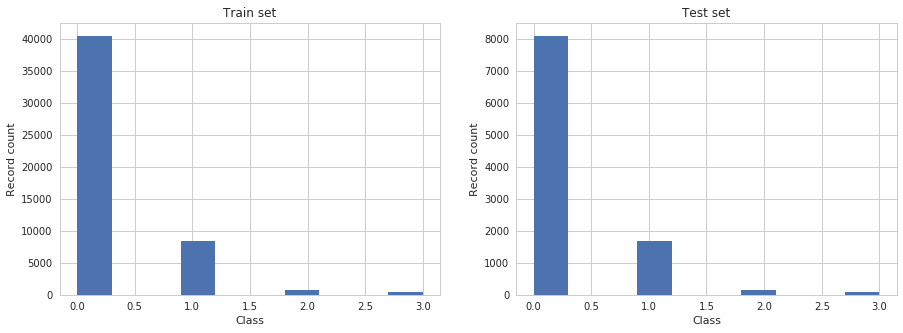

In [34]:
plot_class_hist(data_train, data_test)

## RFC

### Train model with all features

In [35]:
model = RandomForestClassifier(n_jobs=-1, class_weight="balanced")

with joblib.parallel_backend('dask'):
    model.fit(X_train, y_train)

# Sort feature importances in descending order and rearrange feature names accordingly
indices = np.argsort(model.feature_importances_)[::1]
names = [options.feature_params[i] for i in indices]

Visualise trained model performance

<Figure size 432x288 with 0 Axes>

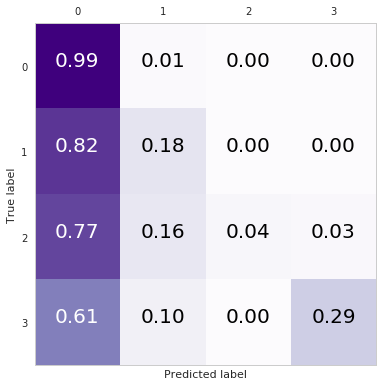

In [36]:
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Purples)

### Train with SMOTE

In [53]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)

In [54]:
data_train_res = X_res.copy()
data_train_res.loc[:, 'class'] = y_res.ravel()

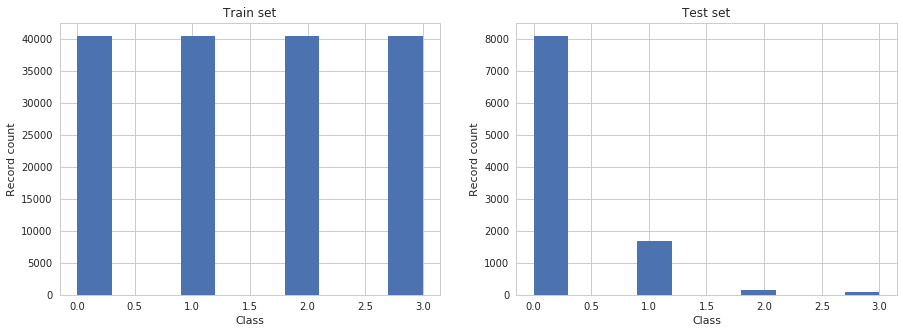

In [46]:
plot_class_hist(data_train_res, data_test)

In [47]:
model_res = RandomForestClassifier(n_jobs=-1)

with joblib.parallel_backend('dask'):
    model_res.fit(X_res, y_res)

# Sort feature importances in descending order and rearrange feature names accordingly
indices_res = np.argsort(model_res.feature_importances_)[::1]
names_res = [options.feature_params[i] for i in indices_res]

<Figure size 432x288 with 0 Axes>

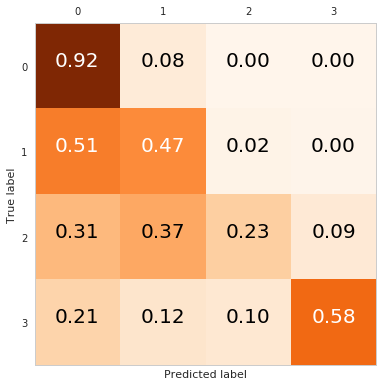

In [48]:
y_pred_res = model_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred_res, range(0,4), normalize=True, cmap=plt.cm.Oranges)

### Run feature selection

In [77]:
param_grid = {"n_estimators": [10, 100, 150, 200, 250, 500, 800],
              "max_depth": [3, 10, 20, 50, None],
              "max_features": ["auto", "sqrt", "log2", None],
              "min_samples_split": [2,5,10,50],
              "min_samples_leaf": [1, 2, 4, 10, 20],
              "bootstrap": [True, False]}

Use smoted data and model

In [ ]:
cv_results = None
print('..performing cv search...')
searches = []

# Define jobs
#for i in range(0,5):
for i in range(0,len(names)-4):

    X = X_res.loc[:, names[i:]].values
    
    random_search = dcv.RandomizedSearchCV(model_res, 
                                           param_grid, 
                                           n_iter=20,
                                           scoring=['f1_macro', 'f1_micro', 'accuracy'],
                                           return_train_score=True,
                                           refit=False)
    searches.append((random_search, X, y_res))

# Fit
i = 0
for s, X, y in searches:
    print('...fitting with {} parameters'.format(len(names)-i))
    s.fit(X, y)
    i += 1

# Gather results
i = 0
for random_search, _, __ in searches:
    if cv_results is None:
        cv_results = pd.DataFrame(random_search.cv_results_) #.head(1)
        cv_results['Number of parameters'] = len(names)-i
    else:
        res_df = pd.DataFrame(random_search.cv_results_) #.head(1)
        res_df['Number of parameters'] = len(names)-i
        cv_results = pd.concat([cv_results, res_df], ignore_index=True)
    i += 1

print('..cv search done')
cv_results.sort_values(by=['mean_test_f1_macro'], inplace=True, ascending=False, ignore_index=True)

..performing cv search...
...fitting with 40 parameters
...fitting with 39 parameters
...fitting with 38 parameters
...fitting with 37 parameters
...fitting with 36 parameters
...fitting with 35 parameters
...fitting with 34 parameters
...fitting with 33 parameters
...fitting with 32 parameters
...fitting with 31 parameters
...fitting with 30 parameters
...fitting with 29 parameters
...fitting with 28 parameters


In [16]:
cv_results

,id,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,mean_test_f1_macro,...,split2_train_accuracy,mean_train_accuracy,std_train_accuracy,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,Number of parameters
0,138,"{'n_estimators': 800, 'min_samples_split': 2, ...",740.298995,175.825158,41.050695,1.864776,0.905146,0.951762,0.952248,0.936385,...,1.000000,1.000000,0.000000,800,2,1,sqrt,50.0,False,34
1,106,"{'n_estimators': 250, 'min_samples_split': 2, ...",187.650037,1.628299,12.866681,0.595570,0.905327,0.951298,0.950053,0.935559,...,1.000000,1.000000,0.000000,250,2,1,auto,50.0,False,35
2,175,"{'n_estimators': 250, 'min_samples_split': 2, ...",202.885257,1.192826,12.923678,0.240340,0.902835,0.952339,0.950668,0.935280,...,1.000000,1.000000,0.000000,250,2,1,auto,NaN,False,32
3,15,"{'n_estimators': 800, 'min_samples_split': 5, ...",983.182513,171.550055,82.120067,59.825486,0.901043,0.949841,0.949798,0.933560,...,1.000000,0.999997,0.000004,800,5,1,auto,NaN,False,40
4,30,"{'n_estimators': 500, 'min_samples_split': 5, ...",621.385768,85.152726,78.899541,36.966768,0.902415,0.949510,0.948732,0.933552,...,1.000000,0.999997,0.000004,500,5,1,log2,NaN,False,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,638,"{'n_estimators': 500, 'min_samples_split': 5, ...",89.283652,1.353532,5.128762,0.016567,0.351176,0.380227,0.379064,0.370155,...,0.426870,0.429303,0.002203,500,5,10,auto,3.0,False,9
716,672,"{'n_estimators': 100, 'min_samples_split': 2, ...",32.145494,12.805678,2.087868,1.485773,0.344744,0.354652,0.354692,0.351363,...,0.407831,0.408836,0.001010,100,2,1,NaN,3.0,True,7
717,657,"{'n_estimators': 800, 'min_samples_split': 50,...",284.139313,79.080655,8.372279,0.384427,0.343512,0.354827,0.354660,0.351000,...,0.407645,0.408567,0.000966,800,50,1,NaN,3.0,True,8
718,652,"{'n_estimators': 100, 'min_samples_split': 2, ...",40.477246,12.996432,2.303904,1.784570,0.343060,0.354622,0.354788,0.350823,...,0.407562,0.408515,0.000992,100,2,2,NaN,3.0,True,8


### Save/load CV results

In [13]:
fname = 'results/feature_selection_rfc_results.csv'.format(options.output_path)

In [ ]:
# Save and visualise results
fh.df_to_csv(cv_results, fname, fname)

In [14]:
# load
cv_results = pd.read_csv(fname)

In [15]:
cv_results

,id,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,mean_test_f1_macro,...,split2_train_accuracy,mean_train_accuracy,std_train_accuracy,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,Number of parameters
0,138,"{'n_estimators': 800, 'min_samples_split': 2, ...",740.298995,175.825158,41.050695,1.864776,0.905146,0.951762,0.952248,0.936385,...,1.000000,1.000000,0.000000,800,2,1,sqrt,50.0,False,34
1,106,"{'n_estimators': 250, 'min_samples_split': 2, ...",187.650037,1.628299,12.866681,0.595570,0.905327,0.951298,0.950053,0.935559,...,1.000000,1.000000,0.000000,250,2,1,auto,50.0,False,35
2,175,"{'n_estimators': 250, 'min_samples_split': 2, ...",202.885257,1.192826,12.923678,0.240340,0.902835,0.952339,0.950668,0.935280,...,1.000000,1.000000,0.000000,250,2,1,auto,NaN,False,32
3,15,"{'n_estimators': 800, 'min_samples_split': 5, ...",983.182513,171.550055,82.120067,59.825486,0.901043,0.949841,0.949798,0.933560,...,1.000000,0.999997,0.000004,800,5,1,auto,NaN,False,40
4,30,"{'n_estimators': 500, 'min_samples_split': 5, ...",621.385768,85.152726,78.899541,36.966768,0.902415,0.949510,0.948732,0.933552,...,1.000000,0.999997,0.000004,500,5,1,log2,NaN,False,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,638,"{'n_estimators': 500, 'min_samples_split': 5, ...",89.283652,1.353532,5.128762,0.016567,0.351176,0.380227,0.379064,0.370155,...,0.426870,0.429303,0.002203,500,5,10,auto,3.0,False,9
716,672,"{'n_estimators': 100, 'min_samples_split': 2, ...",32.145494,12.805678,2.087868,1.485773,0.344744,0.354652,0.354692,0.351363,...,0.407831,0.408836,0.001010,100,2,1,NaN,3.0,True,7
717,657,"{'n_estimators': 800, 'min_samples_split': 50,...",284.139313,79.080655,8.372279,0.384427,0.343512,0.354827,0.354660,0.351000,...,0.407645,0.408567,0.000966,800,50,1,NaN,3.0,True,8
718,652,"{'n_estimators': 100, 'min_samples_split': 2, ...",40.477246,12.996432,2.303904,1.784570,0.343060,0.354622,0.354788,0.350823,...,0.407562,0.408515,0.000992,100,2,2,NaN,3.0,True,8


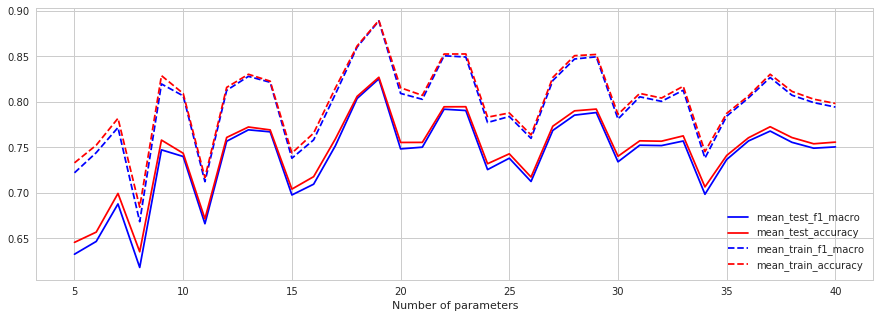

In [18]:
best_results = cv_results.groupby('Number of parameters').mean()
fig, ax = plt.subplots(figsize=(15,5))
best_results.plot(y=['mean_test_f1_macro', 'mean_test_accuracy'], color=['b','r'], ax=ax)
best_results.plot(y=['mean_train_f1_macro', 'mean_train_accuracy'], color=['b', 'r'], linestyle='dashed', ax=ax)

### Retrain with best combination

In [55]:
best_results=cv_results[cv_results.loc[:, 'Number of parameters'] == 19]
best_results.sort_values(by=['mean_test_f1_macro'], inplace=True, ascending=False, ignore_index=True)
best_results

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,id,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,mean_test_f1_macro,...,split2_train_accuracy,mean_train_accuracy,std_train_accuracy,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,Number of parameters
0,438,"{'n_estimators': 200, 'min_samples_split': 2, ...",180.319782,26.516070,9.048812,0.532206,0.904772,0.931491,0.930170,0.922144,...,0.998934,0.998699,0.000393,200,2,1,auto,20.0,False,19
1,436,"{'n_estimators': 200, 'min_samples_split': 10,...",266.203516,79.225901,25.225044,11.890629,0.893351,0.922848,0.921472,0.912557,...,0.993280,0.993400,0.000267,200,10,2,auto,20.0,False,19
2,439,"{'n_estimators': 200, 'min_samples_split': 10,...",109.175896,1.230203,8.893477,0.202919,0.890959,0.922537,0.921078,0.911524,...,0.993521,0.994355,0.001253,200,10,1,auto,50.0,True,19
3,421,"{'n_estimators': 500, 'min_samples_split': 10,...",455.323245,135.692981,62.948644,29.560599,0.888703,0.919928,0.918616,0.909082,...,0.988766,0.989822,0.001985,500,10,2,auto,50.0,True,19
4,434,"{'n_estimators': 250, 'min_samples_split': 10,...",252.840905,81.103119,15.904365,7.772664,0.888131,0.919286,0.917751,0.908389,...,0.988886,0.989340,0.000896,250,10,4,sqrt,20.0,False,19
5,425,"{'n_estimators': 10, 'min_samples_split': 5, '...",8.790496,2.421385,1.378953,0.780607,0.858712,0.884841,0.884416,0.875990,...,0.967187,0.968942,0.003286,10,5,4,sqrt,NaN,True,19
6,437,"{'n_estimators': 100, 'min_samples_split': 50,...",92.803723,27.884869,3.450922,0.019115,0.855631,0.884784,0.887049,0.875821,...,0.935884,0.939481,0.006455,100,50,4,auto,20.0,False,19
7,435,"{'n_estimators': 150, 'min_samples_split': 5, ...",459.556141,126.940406,8.455081,4.692340,0.833508,0.887832,0.885762,0.869034,...,0.937979,0.941273,0.005856,150,5,10,NaN,NaN,True,19
8,428,"{'n_estimators': 200, 'min_samples_split': 2, ...",160.123717,29.377319,6.948568,0.043813,0.848355,0.878706,0.877212,0.868091,...,0.923955,0.928521,0.007449,200,2,20,sqrt,50.0,False,19
9,427,"{'n_estimators': 150, 'min_samples_split': 2, ...",107.416990,4.309644,5.071178,0.044090,0.843629,0.873130,0.872622,0.863127,...,0.918968,0.923571,0.007102,150,2,20,auto,20.0,False,19


In [56]:
best_params = ast.literal_eval(best_results.loc[0,'params'])
model = RandomForestClassifier(**best_params)
params = names_res[0:best_results.loc[0, 'Number of parameters']]
print('Using following params ({}): {}'.format(len(params), ','.join(params)))
print('Using configuration: {}'.format(best_params))
data = X_res.loc[:, params]

with joblib.parallel_backend('dask'):
    model.fit(data, y_res)

Using following params (19): MAX Precipitation kg/m2,AVG Snowdepth,MIN Snowdepth,MIN Snowfall,AVG Precipitation kg/m2,AVG Snowfall,MIN Precipitation kg/m2,MAX Snowfall,MAX Snowdepth,SUM Snowfall,SUM Precipitation kg/m2,AVG Total cloud cover,MIN CAPE,STD Wind gust,STD Wind Speed,AVG CAPE,MAX CAPE,MIN Temperature,MIN Total column water vapor
Using configuration: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}


<Figure size 432x288 with 0 Axes>

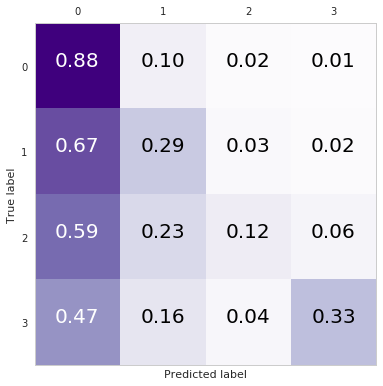

In [57]:
y_pred = model.predict(X_test.loc[:, params])
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Purples)

## SVC

### Train model with all features

In [58]:
from sklearn.svm import SVC
model_svc = SVC(class_weight="balanced")

with joblib.parallel_backend('dask'):
    model_svc.fit(X_train, y_train)

Visualise trained model performance

<Figure size 432x288 with 0 Axes>

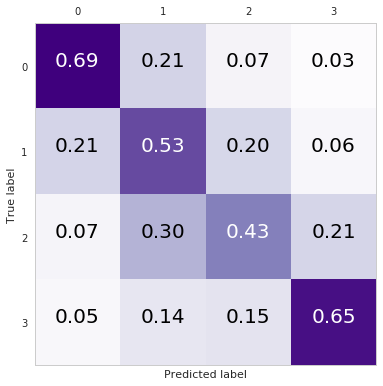

In [59]:
y_pred_svc = model_svc.predict(X_test)
plot_confusion_matrix(y_test, y_pred_svc, range(0,4), normalize=True, cmap=plt.cm.Purples)

### Train with SMOTE

<Figure size 432x288 with 0 Axes>

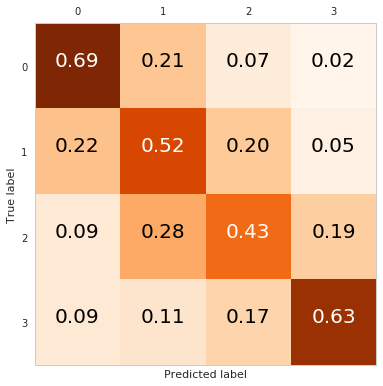

In [60]:
model_svc_res = SVC()

with joblib.parallel_backend('dask'):
    model_svc_res.fit(X_res, y_res)
    
y_pred = model_svc_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Oranges)

### Random Search for SVC

In [4]:
from scipy.stats import expon
num_of_params = 35
param_grid = {'C': expon(scale=100), 
              'gamma': expon(scale=.1),
              'kernel':  ['linear', 'rbf', 'sigmoid'],
              'coef0': expon(scale=1)
             }

random_search = dcv.RandomizedSearchCV(SVC(), 
                                       param_grid, 
                                       n_iter=50,
                                       #scoring=['f1_macro', 'f1_micro', 'accuracy'],
                                       return_train_score=True,
                                       refit=False)
random_search.fit(X_res, y_res)
cv_results_svc = pd.DataFrame(random_search.cv_results_)
cv_results_svc.head()

NameError: name 'SVC' is not defined

In [88]:
cv_results_svc

NameError: name 'cv_results_svc' is not defined

In [23]:
# Save and visualise results
fname = 'results/random_search_cv_svc_results.csv'.format(options.output_path)
fh.df_to_csv(cv_results_svc, fname, fname)

In [ ]:
y_pred = model_svc_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Oranges)